<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_3/Figure_3a/3_human_SARSCoV_validation_smartseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation using SARS-CoV2 infected human iPSC derived cardiomyocytes
Data from https://www.cell.com/cell-reports-medicine/pdf/S2666-3791(20)30068-9.pdf:

In [1]:
# Number of threads to use during alignments
threads = 20 # Change to 2 if not using TPU runtime

## Install software

In [2]:
!pip install -q ffq gget kb_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 71.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 33.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.5 MB/s eta 

## Download SMART-Seq data

In [3]:
import json
import glob

# Get ftp download links for raw data with ffq and store results in json file
!ffq SRR11777734 SRR11777735 SRR11777736 SRR11777737 SRR11777738 SRR11777739 \
    --ftp \
    -o ffq.json

# Load ffq output
f = open("ffq.json")
data_json = json.load(f)
f.close()

# Download raw data using FTP links fetched by ffq
for dataset in data_json:
    url = dataset["url"]
    !curl -O $url

[2023-12-08 23:24:38,992]    INFO Parsing run SRR11777734
[2023-12-08 23:24:41,392]    INFO Parsing run SRR11777735
[2023-12-08 23:24:43,635]    INFO Parsing run SRR11777736
[2023-12-08 23:24:46,073]    INFO Parsing run SRR11777737
[2023-12-08 23:24:49,282]    INFO Parsing run SRR11777738
[2023-12-08 23:24:51,941]    INFO Parsing run SRR11777739
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2962M  100 2962M    0     0  37.5M      0  0:01:18  0:01:18 --:--:-- 38.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2634M  100 2634M    0     0  42.1M      0  0:01:02  0:01:02 --:--:-- 43.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2484M  100 2484M

## Download optimized PalmDB reference files


In [4]:
# Download the ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

--2023-12-08 23:32:24--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M   123MB/s    in 0.2s    

2023-12-08 23:32:24 (123 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]

--2023-12-08 23:32:25--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

## Build virus reference index from PalmDB amino acid sequences and mask host (here, human) sequences
You can find the kb manual and tutorials [here](https://www.kallistobus.tools/).

The --aa argument tells kb that this is an amino acid reference.

The --d-list argument is the path to the host transcriptome. These sequences will be masked in the index. Here, we are using gget to fetch the human genome and transcriptome (release 110).

We are using --workflow custom here since we do not have a .gtf file for the PalmDB fasta file.

Building the index will take some time (~20 min), since the human genomes is quite large.

In [5]:
!gget ref -r 110 -w cdna,dna -d human

Fri Dec  8 23:32:42 2023 INFO Fetching reference information for homo_sapiens from Ensembl release: 110.
{
    "homo_sapiens": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz",
            "ensembl_release": 110,
            "release_date": "2023-04-22",
            "release_time": "04:25",
            "bytes": "75M"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz",
            "ensembl_release": 110,
            "release_date": "2023-04-21",
            "release_time": "17:28",
            "bytes": "841M"
        }
    }
}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.2M  100 75.2M    0     0   634k      0  0:02:01  0:02:01 --:--:--  639k
  % Total    

In [6]:
# Concatenate human genome and transcriptome into one file
!cat Homo_sapiens.GRCh38.cdna.all.fa.gz Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz > Homo_sapiens.GRCh38.cdna_dna.fa.gz

In [ ]:
%%time
!kb ref \
  --workflow custom \
  --aa \
  --d-list Homo_sapiens.GRCh38.cdna_dna.fa.gz \
  -t $threads \
  -i index.idx \
  palmdb_rdrp_seqs.fa

## Align data using kallisto translated search

Get fastq files:

In [ ]:
fastqs = []
for filename in glob.glob("*.fastq.gz"):
    fastqs.append(filename.split("/")[-1])

fastqs.sort()
fastqs

Loop over files and align one at a time (alternative: use a batch file to align multiple fastqs at the same time). The `-x` techology tells kb where to find the barcode and UMI in the data. We will treat the SMART-Seq data like bulk data for this validation.

In [ ]:
%%time
for fastq in fastqs:
    sample = fastq.split(".fastq.gz")[0]

    # !mkdir -p $sample

    !kb count \
        --aa \
        -t $threads \
        -i index.idx \
        -g palmdb_clustered_t2g.txt \
        -x bulk \
        --parity single \
        --out $sample \
        $fastq

    # !$kallisto bus \
    #         -i index.idx \
    #         -o $sample/ \
    #         --aa \
    #         -t 30 \
    #         -x bulk \
    #         $fastq_folder/$fastq \
    #         &> $sample/kb_out.txt

    # !$bustools sort -o $sample/output_sorted.bus $sample/output.bus

    # !$bustools count \
    #     --genecounts \
    #     --cm \
    #     -o $sample/bustools_count/ \
    #     -g $virus_t2g \
    #     -e $sample/matrix.ec \
    #     -t $sample/transcripts.txt \
    #     $sample/output_sorted.bus

 all fits in buffer
Read in 16651 BUS records
reading time 0s
sorting time 0s
writing time 0s
 all fits in buffer
Read in 20606 BUS records
reading time 0s
sorting time 0.01s
writing time 0s
 all fits in buffer
Read in 15362 BUS records
reading time 0s
sorting time 0.01s
writing time 0s
 all fits in buffer
Read in 1801 BUS records
reading time 0s
sorting time 0s
writing time 0s
 all fits in buffer
Read in 2244 BUS records
reading time 0s
sorting time 0s
writing time 0s
 all fits in buffer
Read in 1802 BUS records
reading time 0s
sorting time 0s
writing time 0s
CPU times: user 38.9 s, sys: 9.22 s, total: 48.2 s
Wall time: 40min 38s


## Plot virus counts

In [ ]:
!pip install -q kb_python

import kb_python.utils as kb_utils
import anndata
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors
%config InlineBackend.figure_format='retina'

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [ ]:
u_tax_csv = "ID_to_taxonomy_mapping.csv"

Create adata objects from count matrices:

In [ ]:
adatas = []
for fastq in fastqs:
    # Load data
    sample = fastq.split(".fastq.gz")[0]

    # Filepath to counts
    X = f"{sample}/bustools_count/output.mtx"
    # Filepath to barcode metadata
    var_path = f"{sample}/bustools_count/output.genes.txt"
    # Filepath to gene metadata
    obs_path = f"{sample}/bustools_count/output.barcodes.txt"

    # Create AnnData object
    adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

    # Add sample name
    adata.obs["sample"] = sample

    # Append to adata list
    adatas.append(adata)

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype exp

In [ ]:
adata = anndata.concat(adatas, merge="same")
# Set sample as index
adata.obs = adata.obs.set_index("sample")
adata.obs

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


""
sample
Cov1
Cov2
Cov3
Mock1
Mock2
Mock3


In [ ]:
tax_df = pd.read_csv(u_tax_csv)
tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
404,u889,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
405,u9015,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
406,u944,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
407,u9771,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


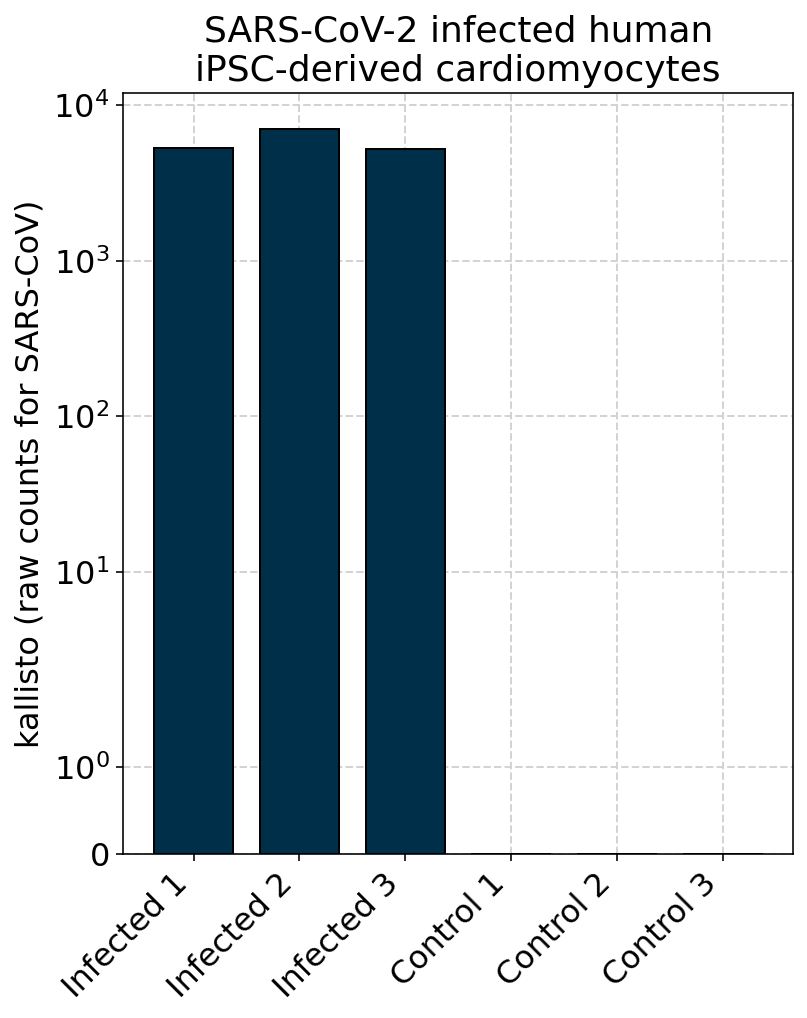

In [ ]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 16
width = 0.75

x_labels = ['Infected 1', 'Infected 2', 'Infected 3', 'Control 1', 'Control 2', 'Control 3']

target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].unique()

counts = []
samples = adata.obs.index.values
labels = samples
for sample in samples:
    counts.append(adata.X[adata.obs.index == sample, adata.var.index.isin(target_ids)].sum())

x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#003049", edgecolor="black")

ax.set_yscale("symlog")
ax.set_ylabel("kallisto (raw counts for SARS-CoV)", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)

ax.set_xticks(x, x_labels, rotation=45, ha="right")

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"SARS-CoV-2 infected human\niPSC-derived cardiomyocytes", fontsize=fontsize+2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# plt.tight_layout()

plt.savefig("smartseq_benchmark_PRJNA631969.png", dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
counts

[5265.0, 7037.0, 5187.0, 0.0, 0.0, 0.0]